### TODO:

###### Build up fundamental model:
-Test speeds vs traditional methods  
-Energy distance test for distributions  
-Check distributions of variables within households, compare to naive method w/borysov model somehow  
-Test making epsilon the same distribution as the actual posteriors in the model

###### Differentiate from the GenSynth paper:
-Travel diaries  
-Method/heuristic/rules for checking large number of attributes  
-New models; Disentangled VAE/GAN  
-Model population changes over time RNN?  
-Behavioral variables  

###### They suggest:
-Incorporate RNN to generate trip chains (time, location, mode, purpose)  
-Use GAN/other method to generate less inconsistencies  
-Address next stage of re-sampling to get future populations  

In [1]:
# Each input to training the model is a person's daily trip diary
# Inputs; day of week, characteristics of person/hh
# Outputs; trip purpose, mode, duration, distance
# How to include Time of Day?
# Timesteps could either be hours in the day, or trips in a chain?
    # If a timestep is a trip, add the time of departure to the output variables
    
# Timestep is a trip
# Output of each timestep is departure time, duration, distance, mode, and purpose (y)
# Input of each timestep is person/hh variables, day of week, and previous timestep info (x)

## Import Libraries and Datasets

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.preprocessing as skpre
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
# Load in the persons PUMS dataset for WA state
t_df = pd.read_csv('data/NHTS/nhts_survey/trippub.csv')
p_df = pd.read_csv('data/NHTS/nhts_survey/perpub.csv')
h_df = pd.read_csv('data/NHTS/nhts_survey/hhpub.csv')

## Choose Variables and Preprocess

In [4]:
# Filter to desired variables (numeric then categorical)
#TRIPPURP = simplified why/from
nhts_data_t = t_df[['TDCASEID','HOUSEID','PERSONID','TDAYDATE','TRAVDAY','TDTRPNUM','STRTTIME','TRVLCMIN','TRPMILES','TRPTRANS','WHYFROM','WHYTO']]
nhts_data_p = p_df[['HOUSEID','PERSONID','R_AGE','TIMETOWK','EDUC','R_SEX','OCCAT']]
nhts_data_h = h_df[['HOUSEID','HHSIZE','HHFAMINC','HHVEHCNT']]
del t_df
del p_df
del h_df
nhts_data = pd.merge(nhts_data_t, nhts_data_h, on='HOUSEID', how='left')
nhts_data = pd.merge(nhts_data, nhts_data_p, on=['HOUSEID', 'PERSONID'], how='left')

# Give each set of daily trips a unique chain id (each will be an input to model)
nhts_data['CHAINID'] = nhts_data.groupby(['TDAYDATE','HOUSEID','PERSONID']).ngroup().values
nhts_data = nhts_data.drop(labels=['TDAYDATE','TDCASEID','HOUSEID','PERSONID'], axis=1)

# Remove NA values and check n before/after
print(f"Dataset n={len(nhts_data)} pre-cleaning")
nan_indices = list((nhts_data < 0).any(axis=1))
nan_ids = nhts_data[nan_indices][['CHAINID']].values.flatten()
nhts_data = nhts_data[~(nhts_data['CHAINID'].isin(nan_ids))]
print(f"Dataset n={len(nhts_data)} post-cleaning")

Dataset n=923572 pre-cleaning
Dataset n=405590 post-cleaning


In [5]:
# Only numeric variables, only dynamic variables
nhts_data = nhts_data[['TRAVDAY','TDTRPNUM','STRTTIME','TRVLCMIN','TRPMILES','TRPTRANS','CHAINID']].copy()

In [6]:
# Preview data that will be fed into model
model_data_df = nhts_data
model_data_df

,TRAVDAY,TDTRPNUM,STRTTIME,TRVLCMIN,TRPMILES,TRPTRANS,CHAINID
2,2,1,700,120,84.004,6,46938
3,2,2,1800,150,81.628,6,46938
6,5,1,1115,15,8.017,6,46940
7,5,2,2330,10,8.017,6,46940
8,5,1,550,15,3.395,4,24626
...,...,...,...,...,...,...,...
923567,3,1,810,27,1.168,1,93638
923568,3,2,1320,8,0.238,1,93638
923569,3,3,1415,5,0.238,1,93638
923570,3,4,1820,25,0.867,1,93638


In [7]:
# Remove chains that have more than 5 trips in them
MAX_TIMESTEPS = 5
long_chains = model_data_df[model_data_df['TDTRPNUM'] > MAX_TIMESTEPS][['CHAINID']].values.flatten()
model_data_df = model_data_df[~model_data_df['CHAINID'].isin(long_chains)]
print(len(pd.unique(long_chains)))

## Remove outliers
# Filter model data into train/test data
chain_ids = pd.unique(model_data_df['CHAINID'])
train_idx = round(len(chain_ids)*.9)
train_ids = chain_ids[0:train_idx]
test_ids = chain_ids[train_idx:len(chain_ids)]
train_data_df = model_data_df[model_data_df['CHAINID'].isin(train_ids)]
test_data_df = model_data_df[model_data_df['CHAINID'].isin(test_ids)]

# Standardize the input data from -1 to 1 for numerical variables, remove outliers (x > 3 SD)
scaler_train = skpre.StandardScaler()
scaler_test = skpre.StandardScaler()
train_data = scaler_train.fit_transform(train_data_df.values)
test_data = scaler_test.fit_transform(test_data_df.values)

# Remove outliers from dataset once for training data...
outlier_indices = np.where(np.any(train_data > 3, axis=1))[0]
outlier_chains = train_data_df.iloc[outlier_indices,:][['CHAINID']].values.flatten()
train_data_df = train_data_df[~train_data_df['CHAINID'].isin(outlier_chains)]
print(len(outlier_chains))

# ...and again for testing data (keep the scalers separate)
outlier_indices = np.where(np.any(test_data > 3, axis=1))[0]
outlier_chains = test_data_df.iloc[outlier_indices,:][['CHAINID']].values.flatten()
test_data_df = test_data_df[~test_data_df['CHAINID'].isin(outlier_chains)]
print(len(outlier_chains))

23897
3463
378


In [57]:
# Reshape the model data to a format that is usable by tensorflow: shape = (#samples, timestep size, #features)
# TODO: Make sure this is working correctly
train_samples = []
chain_ids = pd.unique(train_data_df['CHAINID'])

# This could be faster
for chain_id in chain_ids:
    data = train_data_df[train_data_df['CHAINID'] == chain_id].values
    data = scaler_train.fit_transform(data).transpose()
    data = keras.preprocessing.sequence.pad_sequences(data, MAX_TIMESTEPS, padding='post').transpose()
    train_samples.append(data)

# (samples, timesteps, features)
train_data = np.array(train_samples)

In [58]:
# Reshape the model data to a format that is usable by tensorflow
test_samples = []
chain_ids = pd.unique(test_data_df['CHAINID'])

# This could be faster
for chain_id in chain_ids:
    data = test_data_df[test_data_df['CHAINID'] == chain_id].values
    data = scaler_test.fit_transform(data).transpose()
    data = keras.preprocessing.sequence.pad_sequences(data, MAX_TIMESTEPS, padding='post').transpose()
    test_samples.append(data)

# (samples, timesteps, features)
test_data = np.array(test_samples)

In [59]:
# shape = (#samples, timestep size, #features)
print(train_data.shape)
print(test_data.shape)

(61963, 5, 7)
(6904, 5, 7)


## Set Parameters and Define Model

In [98]:
# Timestep is a trip
# Output of each timestep is departure time, duration, distance, mode, and purpose (dynamic)
# Input of each timestep is person/hh variables, day of week, and previous timestep info (static + dynamic)

# Hyperparameters
BATCH_SIZE = 10
EPOCHS = 5
LEARN_RATE = 0.01
RHO = 0.9
MANIFEST_DIM = train_data.shape[2]

In [103]:
# LSTM layer requires inputs to be 3D tensor with shape [batch, timesteps, feature]
inputs = keras.Input(shape=(MAX_TIMESTEPS, MANIFEST_DIM))
dense = layers.Dense(10)(inputs)
lstm = layers.LSTM(10, return_sequences=True)(dense)
outputs = layers.Dense(MANIFEST_DIM)(lstm)

# Define and print model
model = keras.Model(inputs, outputs)
model.summary()

Model: "functional_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_28 (InputLayer)        [(None, 5, 7)]            0         
_________________________________________________________________
dense_39 (Dense)             (None, 5, 10)             80        
_________________________________________________________________
lstm_48 (LSTM)               (None, 5, 10)             840       
_________________________________________________________________
dense_40 (Dense)             (None, 5, 7)              77        
Total params: 997
Trainable params: 997
Non-trainable params: 0
_________________________________________________________________


## Training

In [104]:
# Compile and train the model
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.RMSprop(learning_rate=LEARN_RATE, rho=RHO))
history = model.fit(train_data, train_data, epochs=EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/5
6197/6197 [==============================] - 28s 4ms/step - loss: 0.0015
Epoch 2/5
6197/6197 [==============================] - 26s 4ms/step - loss: 4.1532e-04
Epoch 3/5
6197/6197 [==============================] - 25s 4ms/step - loss: 3.0878e-04
Epoch 4/5
6197/6197 [==============================] - 26s 4ms/step - loss: 2.7703e-04
Epoch 5/5
6197/6197 [==============================] - 27s 4ms/step - loss: 2.5291e-04


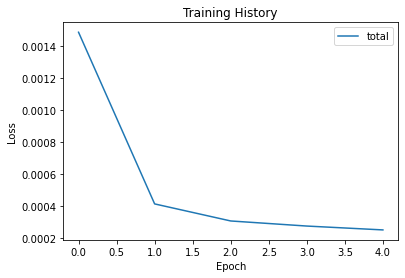

In [105]:
# Plot model loss/training progress
plt.plot(history.history['loss'])
plt.title("Training History")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["total"], loc="upper right")
plt.show()

## Testing

In [ ]:
# Get latent vars from the encoder; feed to decoder and get sampled manifest variables
z_mean, z_logvar, z = vae.encoder.predict(test_data[:,:MANIFEST_DIM])

# Record the posterior trained distributions for z
latent_means = []
latent_vars = []

# Determine the average values for the mean/logvariance of the latent variables
for i in range(0, LATENT_DIM):
    epsilon = np.random.normal(loc=0, scale=1, size=1000)
    avg_mean = np.mean(z_mean[:,i])
    latent_means.append(avg_mean)
    avg_var = np.exp(np.mean(z_logvar[:,i]))
    latent_vars.append(avg_var)
    print(f"Latent Variable: {i}")
    print(f"Mean: {avg_mean}")
    print(f"Variance: {np.exp(avg_var)}\n")
    samples = avg_mean + (avg_var * epsilon)
    plt.hist(samples, bins=50)
    plt.show()

In [ ]:
# Draw predictions from test data
results = vae.predict(test_data)
loss_num, loss_cat = get_reconstruction_loss(test_data, results, CAT_IDX, CAT_LENGTHS)
print(f"Numerical Variable Loss: {loss_num}")
print(f"Categorical Variable Loss: {loss_cat}")

In [ ]:
# Transform numeric results back to real variable values
results_num = scaler_pers.inverse_transform(results[0])
results_df = pd.DataFrame(results_num)

# Transform categorical results back to real variable values
for x in results[1]:
    result = np.argmax(x, axis=1) + 1
    results_df[f"{x}"] = result

# Add back original variables names to the results
results_df.columns = VAR_NAMES

In [ ]:
# Transform numeric test data back to real variable values
test_data_num = scaler_pers.inverse_transform(test_data[:,:CAT_IDX])
test_data_df = pd.DataFrame(test_data_num)

# Transform categorical test data back to real variable values
current = CAT_IDX
for x in CAT_LENGTHS:
    test_data_cat = test_data[:,current:(current + x)]
    test_data_cat = np.argmax(test_data_cat, axis=1) + 1
    test_data_df[f"{x}"] = test_data_cat
    current += x

# Add back original variables names to the test data
test_data_df.columns = VAR_NAMES

In [ ]:
# Show distributions of the resulting numerical variables
for col_idx in range(0, CAT_IDX):
    results_data_plt = results_df.iloc[:,col_idx]
    test_data_plt = test_data_df.iloc[:,col_idx]

    plt.hist(results_data_plt, bins=100)
    plt.xlim(min(test_data_plt),max(test_data_plt))
    plt.title(f"var {col_idx} - reconstructed distribution")
    plt.show()

    plt.hist(test_data_plt, bins=100)
    plt.xlim(min(test_data_plt),max(test_data_plt))
    plt.title(f"var {col_idx} - prior distribution")
    plt.show()

In [ ]:
# Show distributions of the resulting categorical variables
for col_idx in range(CAT_IDX, VAR_DIM):
    results_data_plt = results_df.iloc[:,col_idx]
    test_data_plt = test_data_df.iloc[:,col_idx]
    
    plt.hist(results_data_plt)
    plt.xlim(min(test_data_plt),max(test_data_plt))
    plt.title(f"var {col_idx} - reconstructed distribution")
    plt.show()
    
    plt.hist(test_data_plt)
    plt.xlim(min(test_data_plt),max(test_data_plt))
    plt.title(f"var {col_idx} - prior distribution")
    plt.show()

## Generating Synthetic Population

In [ ]:
# Use list of households from the test data (in future can be generated with separate vae)
x = pd.DataFrame(test_data[:,MANIFEST_DIM:]).reset_index(drop=True) # Scaled hh_input values
y = model_data_df.iloc[train_idx:][['NP']].reset_index(drop=True) # Unscaled number of persons value
z = pd.concat([x,y],axis=1)
z.columns = ['HINCP','NP','VEH','SIZE']

# Multiply the inputs by the number of persons per household (hh of size 3 becomes 3 rows with same scaled hh inputs)
z = z.reindex(z.index.repeat(z['SIZE']))
z = z[['HINCP','NP','VEH']].values

# Generate random normal sample to represent each latent variable, for each row (different person per row)
epsilon = np.random.normal(loc=0, scale=1, size=(len(z), LATENT_DIM))
inputs = np.concatenate((epsilon, z), axis=-1)

# Generate persons; each person has unique latent input, plus shared hh inputs with their household
results = vae.decoder.predict(inputs)

In [ ]:
# Transform numeric results back to real variable values
results_num = scaler_pers.inverse_transform(results[0])
results_df = pd.DataFrame(results_num)

# Transform categorical results back to real variable values
for x in results[1]:
    result = np.argmax(x, axis=1) + 1
    results_df[f"{x}"] = result

# Add back original variables names to the results
results_df.columns = VAR_NAMES
results_df

In [ ]:
# Show distributions of the resulting numerical variables
for col_idx in range(0, CAT_IDX):
    results_data_plt = results_df.iloc[:,col_idx]
    test_data_plt = test_data_df.iloc[:,col_idx]

    plt.hist(results_data_plt, bins=100)
    plt.xlim(min(test_data_plt),max(test_data_plt))
    plt.title(f"var {col_idx} - reconstructed distribution")
    plt.show()

    plt.hist(test_data_plt, bins=100)
    plt.xlim(min(test_data_plt),max(test_data_plt))
    plt.title(f"var {col_idx} - prior distribution")
    plt.show()

In [ ]:
# Show distributions of the resulting categorical variables
for col_idx in range(CAT_IDX, VAR_DIM):
    results_data_plt = results_df.iloc[:,col_idx]
    test_data_plt = test_data_df.iloc[:,col_idx]
    
    plt.hist(results_data_plt)
    plt.xlim(min(test_data_plt),max(test_data_plt))
    plt.title(f"var {col_idx} - reconstructed distribution")
    plt.show()
    
    plt.hist(test_data_plt)
    plt.xlim(min(test_data_plt),max(test_data_plt))
    plt.title(f"var {col_idx} - prior distribution")
    plt.show()